# 卒業研究：TRAPPIST-1dとeのトランジット解析

## 0. 解析に必要なモジュールの準備

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=18

## 1. データフレームの準備

### 1-1 測光結果を読み込む

測光には福井さんのプログラムafapphotを用いた。  
様々なアパーチャー半径で測光した結果、目で見てライトカーブが綺麗に見えるアパーチャー半径として様々な半径を用意した。  
以下で行うフィッティングを様々な半径で行なった結果BIC等の基準から最も良くフィッティングできた半径として、12,13,14pixを残す。

In [2]:
df = pd.read_csv('TRAPPIST-1_171105_zband.csv', delimiter=',', parse_dates=True)
df = df.drop(['Unnamed: 0'],axis=1)
df.head()

,GJD-2450000,airmass,sky,dx,dy,flux(10),err(10),flux(11),err(11),flux(12),err(12),flux(13),err(13),flux(14),err(14),flux(15),err(15)
0,8062.876429,1.5601,1109.2,-0.027,-2.954,0.998611,0.004243,0.999285,0.004415,0.997248,0.004615,0.997372,0.004839,0.997539,0.005075,0.995310,0.005315
1,8062.877054,1.5560,979.4,-0.084,-2.454,1.003984,0.004132,1.004214,0.004304,1.004072,0.004506,1.003590,0.004729,1.005631,0.004968,1.005165,0.005211
2,8062.877679,1.5516,875.1,-0.130,-1.302,1.006406,0.004044,1.004540,0.004190,1.004198,0.004377,1.003489,0.004581,1.003510,0.004800,1.003624,0.005028
3,8062.878316,1.5472,784.6,-0.433,0.046,1.009209,0.003988,1.008103,0.004117,1.008610,0.004289,1.007227,0.004478,1.007392,0.004681,1.008025,0.004896
4,8062.878941,1.5433,710.4,0.116,-1.458,1.004208,0.003871,1.005043,0.004000,1.005238,0.004162,1.006522,0.004346,1.007340,0.004539,1.006270,0.004736


In [3]:
len(df)

306

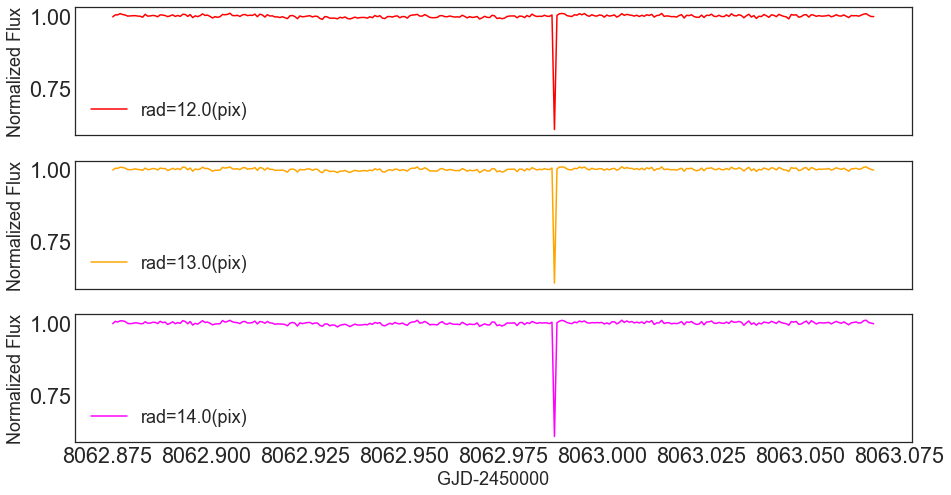

In [4]:
fig,ax = pl.subplots(3,1,figsize=(15,8),sharex=True)

time = df['GJD-2450000']
flux = [ df['flux(12)'],df['flux(13)'],df['flux(14)']]


colors = ['red','orange','magenta']
radii = ['rad=12.0(pix)','rad=13.0(pix)','rad=14.0(pix)']
n=0

# for each band and color do the following:
for c,r in zip(colors,radii):
    ax[n].plot(time, flux[n], label=r, color = c)
    
    #add plot labels
    ax[2].set_xlabel('GJD-2450000')
    ax[n].set_ylabel('Normalized Flux')
    ax[n].legend(loc='lower left')
    
    #increase the axis counter
    n=n+1

pl.savefig('figures/flux_with_outlier.png')

### 1-2 外れ値を除く

上のグラフから、1箇所明らかに外れている値があるのがわかる。確認したところすべておなじフレーム(MSCT2_1711050228)のデータだったので、fluxの平均から$5\sigma$以上離れている点を除くと、その1点だけが除かれた。（おそらくcosmic rayの影響）

In [5]:
sigma = 5
df=df[np.abs(df['flux(12)']-df['flux(12)'].mean())<=(sigma*df['flux(12)'].std())]

In [6]:
len(df)

305

また、airmassについても1点だけおかしい点があったので同様に除いた。　　
<font color=red>こちらはおそらくfits headerの書き込みエラー。前後の値を用いることにして使うデータに戻してやる？</font>

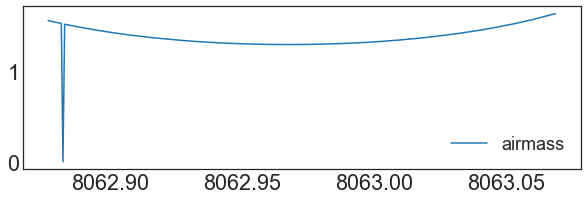

In [7]:
fig,ax = pl.subplots(1,1,figsize=(10,3))
ax.plot(df['GJD-2450000'],df['airmass'],label='airmass')
ax.legend(loc='lower right')

In [8]:
sigma = 5
df=df[np.abs(df['airmass']-df['airmass'].mean())<=(sigma*df['airmass'].std())]

In [9]:
len(df)

304

データ点は304点、プロットすると以下のようになる。

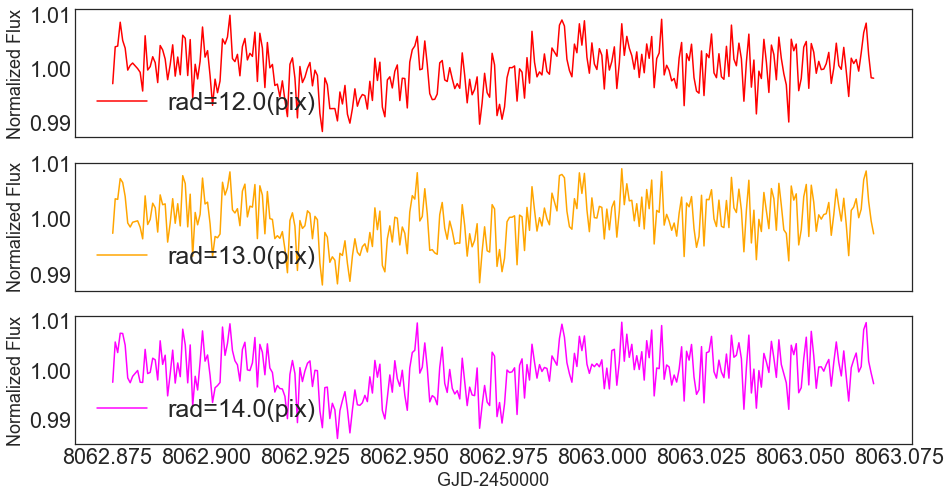

In [10]:
fig,ax = pl.subplots(3,1,figsize=(15,8),sharex=True)

time = df['GJD-2450000']
flux = [ df['flux(12)'],df['flux(13)'],df['flux(14)']]


colors = ['red','orange','magenta']
radii = ['rad=12.0(pix)','rad=13.0(pix)','rad=14.0(pix)']
n=0

# for each band and color do the following:
for c,r in zip(colors,radii):
    ax[n].plot(time, flux[n], label=r, color = c)
    
    #add plot labels
    ax[2].set_xlabel('GJD-2450000')
    ax[n].set_ylabel('Normalized Flux')
    ax[n].legend(loc='lower left',fontsize = 25)
    
    #increase the axis counter
    n=n+1

pl.savefig('figures/flux_3rad.pdf')

左側の凹みがe、右側がdのトランジットと予想されるが、確認はモデルフィットの際に行う。  
最終的に用いるアパーチャー半径は、以下でモデルフィットした際にrmsが一番小さくなるものとする。

## 2. モデルの準備

### 2-1 必要な物理量の代入

In [11]:
from astropy import units as u

#values come from S.Wang et al.(2017) 
tc_0d  = 8062.97518 
_Pd   = 4.04982 #pm 0.00017(days)
_ad   = 0.02145 #semimajor axis (AU)
_Rpd  = 0.772 #pm 0.030 (R_earth)

#from M.Gillon et al.(2017)
_bd   = 0.17 #pm0.11

_Rs = 0.117 #pm 0.0036(Rsun)
k_d = _Rpd/_Rs/u.Rsun.to(u.Rearth)
a_s_d= _ad/_Rs/u.Rsun.to(u.au)

#values come from S.Wang et al.(2017) 
tc_0e= 8062.9449 
_Pe   = 6.099570 #pm 0.000091 (days) w/o TTV
_ae   = 0.02818 #semimajor axis (AU)
_Rpe  = 0.918 #pm0.039 (R_earth)

#from M.Gillon et al.(2017)
_be   = 0.12 #+0.11/-0.09

k_e = _Rpe/_Rs/u.Rsun.to(u.Rearth)
a_s_e= _ae/_Rs/u.Rsun.to(u.au)

主星TRAPPIST-1の有効温度、表面重力、金属量から、プログラムlimdarkを用いて周縁減光の理論値を求める。  
See notes on limb-darkening coefficients: [Espinoza & Jordan (2015)](https://arxiv.org/pdf/1503.07020.pdf)

See also equation 1 in ([Kipping 2013](https://arxiv.org/pdf/1308.0009.pdf)):
$$
\frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
$$
where $\mu=\cos \theta$ is the cosine of the angle between the line of sight and the emergent intensity.

In [12]:
import limbdark as ld

#from M.Gillon(2017)
teff, uteff = 2559,  50 
logg, ulogg = 4.39, 0.03 
feh, ufeh   = 0.04,  0.08 

ldc_list     = []
ldc_err_list = []

ldc = ld.claret("z*", teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
#ldc = u1_,u1err, u2_,u2err

#save in list
#u1,u2
ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
#uncertainties
ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

周縁減光のパラメタとして、$(u_1,u_2)$よりも$(q_1,q_2)$の方が使いやすい(範囲を指定すれば物理的にありえない状況を除ける)ため、変換の式。

In [13]:
def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

In [14]:
q1_,q2_ = u_to_q(ldc[0],ldc[2])

### 2-2 トランジットのモデルを定義する

プログラムpytransitを、二つのトランジットが重なった状況にも適応できるようにした。  

In [15]:
from pytransit import MandelAgol

def transit_model_q(parameters, fix, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * u1 : limb-darkening coefficient (for the linear term)
    * u2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k_d,tc_d,k_e,tc_e = parameters
    p_d,a_d,b_d,p_e,a_e,b_e,q1,q2 = fix
    
    #compute inclination
    inc_d   = np.arccos(b_d/a_d)
    inc_e   = np.arccos(b_e/a_e)
    #convert q to u
    u1,u2 = q_to_u(q1_, q2_)
    #evaluate the model
    m = 1-(1-model.evaluate(time, k_d, (u1,u2), tc_d, p_d, a_d, inc_d))-(1-model.evaluate(time, k_e, (u1,u2), tc_e, p_e,a_e, inc_e))
    
    return m

ためしに生データに理論値を入れたトランジットモデルを重ねると以下のようになる。

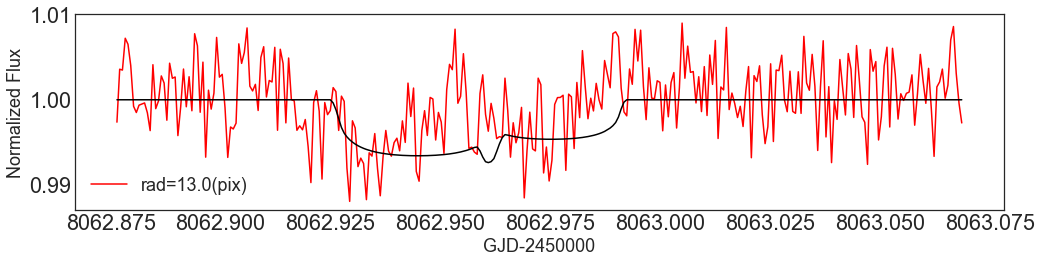

In [16]:
fig,ax = pl.subplots(1,1,figsize=(15,4),sharex=True)

time = df['GJD-2450000']
flux = df['flux(13)']

ax.plot(time, flux, label='rad=13.0(pix)', color ='red')

transit_params_d     = [k_d,tc_0d]
transit_params_e     = [k_e,tc_0e]

transit_params=transit_params_d+transit_params_e

transit_fix = [_Pd,a_s_d,_bd,_Pe,a_s_e,_be,q1_,q2_]

transit_model = transit_model_q(transit_params,transit_fix, time, model=MandelAgol())

ax.plot(time, transit_model , color ='black')

ax.set_xlabel('GJD-2450000')
ax.set_ylabel('Normalized Flux')
ax.legend(loc='lower left')
pl.tight_layout()
pl.savefig('figures/flux_with_theoretical_model.pdf')

TRAPPIST-1に関してはPeriodも変動の可能性が大きいのでtime以外すべてをフリーパラメタとし、初期値は理論値とした。
<font color="CornflowerBlue">transitの方はパラメタを固定したりフリーにしたりしなくていいか？</font>

### 2-3 systematicsのモデルを定義する

systematics = flux / transit_modelとして、各点のsystematics($s_i$)について

$s_i = w_1 X_{i1} + w_2 X_{i2} + \cdots $

という線形の組み合わせが成り立っているとする。($X_{im}$はairmassやdxのような要素、w_mはパラメタとなる重み。)  
これをベクトル表記すると

$\vec{s }= X \cdot \vec{w }$

と表される。pythonの行列計算を用いる。逆行列を求めるため正方行列にする必要があるので以下のようにしている。

$
X^T \cdot s = X^T \cdot X \cdot w \\
(X^T \cdot X)^{-1} \cdot X^T \cdot s = w
$

### 2-3-1. systematicsの組み合わせを用意する

systematicsが上記のような線形の組み合わせで表されると近似した場合、すべての要素を入れれば入れるほど正しい結果になるとは限らず、どの要素を入れるかを考慮する必要がある。  
プログラムを用いてその組み合わせを用意する。

In [17]:
import itertools
free=[['dx'],['dy'],['airmass'],['sky'],['time']]

seq1=['dx','dy','airmass','sky','time']
temp1=list(itertools.combinations(seq1,1))
temp2=list(itertools.combinations(seq1,2))
temp3=list(itertools.combinations(seq1,3))

m=0
for m in range(len(temp3)):
    b=[seq1[n] for n in range(len(seq1)) if not seq1[n] in temp3[m]]
    free.append(b)
    m += 1


m=0
for m in range(len(temp2)):
    b=[seq1[n] for n in range(len(seq1)) if not seq1[n] in temp2[m]]
    free.append(b)
    m += 1
    
m=0
for m in range(len(temp1)):
    b=[seq1[n] for n in range(len(seq1)) if not seq1[n] in temp1[m]]
    free.append(b)
    m += 1


free.append(seq1)
print(free)

[['dx'], ['dy'], ['airmass'], ['sky'], ['time'], ['sky', 'time'], ['airmass', 'time'], ['airmass', 'sky'], ['dy', 'time'], ['dy', 'sky'], ['dy', 'airmass'], ['dx', 'time'], ['dx', 'sky'], ['dx', 'airmass'], ['dx', 'dy'], ['airmass', 'sky', 'time'], ['dy', 'sky', 'time'], ['dy', 'airmass', 'time'], ['dy', 'airmass', 'sky'], ['dx', 'sky', 'time'], ['dx', 'airmass', 'time'], ['dx', 'airmass', 'sky'], ['dx', 'dy', 'time'], ['dx', 'dy', 'sky'], ['dx', 'dy', 'airmass'], ['dy', 'airmass', 'sky', 'time'], ['dx', 'airmass', 'sky', 'time'], ['dx', 'dy', 'sky', 'time'], ['dx', 'dy', 'airmass', 'time'], ['dx', 'dy', 'airmass', 'sky'], ['dx', 'dy', 'airmass', 'sky', 'time']]


上で用意したのは名前の組み合わせなので、ここから実際の値の組み合わせを準備する

In [18]:
df = df.rename(columns={'GJD-2450000': 'time'})
sys_combination = [] 

for n in range(len(free)):
    X=np.ones_like(time)
    m=0
    for m in range(len(free[n])):
        X=np.c_[X,df[free[n][m]]]
        m += 1
    sys_combination.append(X)
    n += 1
#sys_combination

このうちどの組み合わせを$X$として採用するかをフィッティングして（BIC等を基準にして）決めたい。$w$がフリーパラメタとなるが、初期値が適切でないとおかしな結果を出してしまうので、初期値として、OOT(Out-Of-Transit)からざっと求めた値を用いることにする。　　
### 2-3-2 各systematicsの組み合わせについて$\vec{w}$の値を求める
まず、OOTのデータ点(ざっと)を用意する。

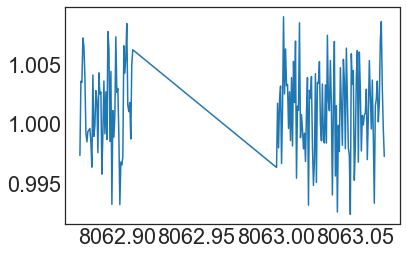

In [19]:
df2 = df[~((df['time']>8062.910) & (df['time']< 8063.00))]
time_OOT = df2['time']
flux_OOT = df2['flux(13)']
pl.plot(time_OOT,flux_OOT)

これについてwを求める

In [20]:
w_before = []
sys_combination_OOT = [] 
n=0
for n in range(len(free)):
    X=np.ones_like(time_OOT)
    m=0
    for m in range(len(free[n])):
        X=np.c_[X,df2[free[n][m]]]
        m += 1
    sys_combination_OOT.append(X)
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, flux_OOT))
    w_before.append(w)
    n += 1
w_before

[array([  1.00147027e+00,   1.40398316e-04]),
 array([  1.00076263e+00,  -4.52039034e-04]),
 array([  1.00050888e+00,   4.59316690e-04]),
 array([  9.99016961e-01,   4.14864774e-06]),
 array([  1.68639805e+01,  -1.96736044e-03]),
 array([  1.82224609e+01,   4.20979157e-06,  -2.13611567e-03]),
 array([  1.72902484e+01,   5.92889132e-04,  -2.02033450e-03]),
 array([  1.00044806e+00,  -1.12028338e-03,   4.52595297e-06]),
 array([  4.39301145e-01,  -4.54401813e-04,   6.96341474e-05]),
 array([  9.98818032e-01,  -4.18098429e-04,   3.79599020e-06]),
 array([  9.98066311e-01,  -5.02699352e-04,   1.82412911e-03]),
 array([ -4.22358424e+01,   4.17165668e-04,   5.36251455e-03]),
 array([  9.99278915e-01,   1.53476455e-04,   4.26310268e-06]),
 array([  1.00051833e+00,   1.44061360e-04,   6.60560241e-04]),
 array([  1.00087350e+00,   4.20295913e-05,  -4.27094172e-04]),
 array([  1.76180701e+01,  -9.89204096e-04,   4.54079993e-06,
         -2.06100014e-03]),
 array([  3.34403136e+00,  -4.08079112e-

これで各systematicsの組み合わせについて$w$のおよその値が求められた。例えば

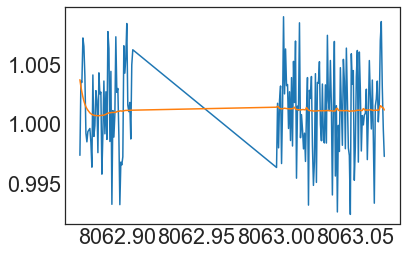

In [21]:
w=w_before[7]
X=sys_combination_OOT[7]
sys_model = np.dot(X,w)

pl.plot(time_OOT,flux_OOT)
pl.plot(time_OOT,sys_model)

## 4. 各パラメタセットでフィットし最も良いセットを決める(MLE)

### 4-1 基準1: Bayesian Information Criteria (BIC)

In [22]:
def rms(flux,flux_model):
    residual = flux-flux_model
    return np.sqrt(np.mean((residual)**2))

def chisq(flux,flux_model,err):
    residual = flux-flux_model
    return np.sum((residual/err)**2)

#BIC = chi2 + num_p * np.log(num_d)

### 4-2 基準2: red noise factor $\beta \times$ rms 

In [23]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return a_b

def beta(residuals, timestep, start_min=5, stop_min=20, return_dict=False):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    
    Final beta is computed by taking the median of the betas:
                np.nanmedian(betas)
    """

    assert timestep < start_min * 60
    ndata = len(residuals)
    
    sigma1 = np.std(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)
    #5*60/50=6points/bin
    #20*60/50=24points/bin

    betas      = []
    betas_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        #6,7,...,24
        nbins = ndata / bs
        #sigmaN_theory = sigma1 / np.sqrt(bs) 最後の項の意味?(Winn J+(2008))
        sigmaN_theory = sigma1 / np.sqrt(bs) * np.sqrt( nbins / (nbins - 1) )
        
        #binning
        sigmaN_actual = np.std(binned(residuals,bs))
        beta = sigmaN_actual / sigmaN_theory
        
        betas_dict[bs] = beta
        betas.append(beta)
        
    #return_dict=TRUEなら辞書を返す、FALSEなら(無記入なら)メディアンとったbetaを返す
    if return_dict:
        return betas_dict
    else:
        return np.nanmedian(betas)

### 4-3 フィッティング

最小にする関数を定義。

In [24]:
import scipy.optimize as op

def obj (params_full, fix, t, f, err):
    '''
    objective function: chi-squared
    '''
    transit_params=params_full[:4]
    sys_params=params_full[4:]
    
    m = transit_model_q(transit_params, fix,t, model=MandelAgol())
    s = np.dot(sys_use,sys_params)
    
    return np.sum(((f-s*m)/err)**2)

使う(最適化する)パラメタを整える。たとえばsystematicsの組み合わせの13番目、['dx', 'airmass']を使うならば、

In [25]:
time = df['time']

flux = df['flux(13)']
err  = df['err(13)']
    
dx   = df['dx']
dy   = df['dy']
airmass = df['airmass']
sky     = df['sky']

transit_params_d     = [k_d,tc_0d]
transit_params_e     = [k_e,tc_0e]

transit_params=transit_params_d+transit_params_e
sys_use = sys_combination[13]
w = w_before[13]

#combine optimized transit params and sys params
full_params = np.concatenate((transit_params, w), axis=0)
full_params

array([  6.04923922e-02,   8.06297518e+03,   7.19326633e-02,
         8.06294490e+03,   1.00051833e+00,   1.44061360e-04,
         6.60560241e-04])

順に、惑星dの$k$,$T_c$、  
惑星eの$k$,$T_c$、    
使用するsystematicsのウェイト$\vec{w}$
である。  

In [26]:
result = op.minimize(obj, full_params, args=(transit_fix,time,flux,err), method='nelder-mead')

#compute flux after optimization
params_after     = np.copy(result.x)
transit_params_after = params_after[:4]
sys_params_after = params_after[4:]

transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
sys_model = np.dot(sys_use,sys_params_after)
print('\nsystematics is' ,free[13])
#compute rms
rms_after = rms(flux/sys_model, transit_model)
print('rms w/o systematics:\n{:.8f}'.format(rms_after))
        
#compute BIC
num_d=len(time)
num_p=full_params.size
chi2 = chisq(flux/sys_model,transit_model,err)
        
dof = num_d - num_p
red_chi2 = chi2 / dof
BIC = chi2 + num_p * np.log(num_d)
        
print('chisq:\n{:.8f}'.format(chi2))
print('reduced_chisq:\n{:.8f}'.format(red_chi2))
print('BIC: {:.4f}'.format(BIC))
    
#compute beta
exptime = 50 #sec
    
resid = flux/sys_model-transit_model
beta_fac = beta(resid, exptime, start_min=5, stop_min=20)
           
inflated_err = err * beta_fac
beta_rms = rms_after * beta_fac
#print('beta factor ={:.4f}'.format(beta_fac))
print('beta * rms ={:.9f}'.format(beta_rms))


systematics is ['dx', 'airmass']
rms w/o systematics:
0.00365901
chisq:
259.55583832
reduced_chisq:
0.87392538
BIC: 299.5750
beta * rms =0.003709130


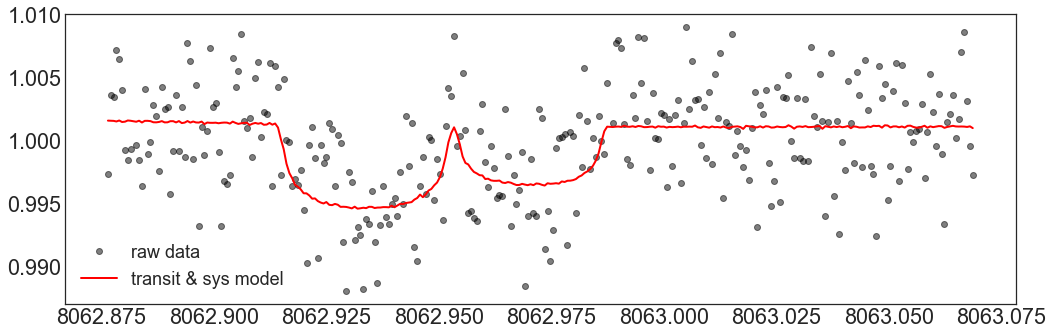

In [27]:
fig = pl.figure(figsize=(15,5))
#plot corrected data
pl.plot(time, flux, 'ko', alpha=0.5, label='raw data')
#pl.set_title('raw data & transit+systematics models (z-band)', fontsize=18)
#plot transit+sys models
pl.plot(time, transit_model*sys_model, 'r-', lw=2, label='transit & sys model');

pl.legend(fontsize=18)
fig.tight_layout()

同様のことを3つのアパーチャー、31パターンのパラメタの組み合わせで行い、BICと$\beta \times rms$を計算する。

err-distributionをcehck
result.x

In [28]:
import emcee
from tqdm import tqdm
#emcee.MHSampler for education

logprob = lambda *x: -obj(*x) 

params =result.x
args=(transit_fix,time,flux,err)
dim = len(params)
nwalkers = 100
sampler = emcee.EnsembleSampler(nwalkers, dim, logprob, args=args)

nsteps = 500
# pos0 = [np.array(params) + 1e-4 * np.random.randn(dim) for i in range(nwalkers)]
pos0 = [params + 1e-4 * np.random.randn(dim) for i in range(nwalkers)]
for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps)):
    pass
    

500it [00:45, 10.96it/s]


In [36]:
sampler

TypeError: 'property' object is not callable

In [30]:
idx = np.argmax(sampler.flatlnprobability)
paramsmc = sampler.flatchain[idx]

sampler.flatlnprobability[idx], -result.fun
# idx

(-254.8333685899504, -260.18755305167065)

In [31]:
import emcee
from tqdm import tqdm
sampler = emcee.EnsembleSampler?

def runmc(logprob, params, args=(transit_fix,time,flux,err),nsteps=500):
    dim = len(params)
    nwalkers = 100
    sampler = emcee.EnsembleSampler(nwalkers, dim, logprob, args=args)

    # pos0 = [np.array(params) + 1e-4 * np.random.randn(dim) for i in range(nwalkers)]
    pos0 = [params + 1e-4 * np.random.randn(dim) for i in range(nwalkers)]
    for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps)):
        pass
    idx = np.argmax(sampler.flatlnprobability)
    paramsmc = sampler.flatchain[idx]
    
    return paramsmc, sampler.flatlnprobability[idx]


In [34]:
time = df['time']

radii = ['13pix']
flux_list = [df['flux(13)']]
err_list = [df['err(13)']*0.935]


transit_params_d     = [k_d,tc_0d]
transit_params_e     = [k_e,tc_0e]

transit_params=transit_params_d+transit_params_e

BIC_list = []
rms_list=[]
beta_rms_list = []
reduced_chisq_list = []

transit_params_after_list=[]
w_after=[]


m=0
count = 0

for m in range(len(flux_list)):
    print('\naperture radius =' + radii[m])
    flux = flux_list[m]
    err = err_list[m]
    
    n=0
    for n in range(len(w_before)):
        sys_use = sys_combination[n]
        w = w_before[n]
        full_params = np.concatenate((transit_params, w), axis=0)
    
        result = op.minimize(obj, full_params, args=(transit_fix,time,flux,err), method='nelder-mead')
        resultmc, lnprobmc = runmc(lambda *x: -obj(*x), result.x,args=(transit_fix,time,flux,err),nsteps=100)
        
        if lnprobmc > -result.fun:
            best= resultmc
            print ("mcmc found better solution!!!!!!!")
        else:
            best = result.x
        
        #compute flux after optimization
        params_after     = best
        
        transit_params_after = params_after[:4]
        transit_params_after_list.append(transit_params_after)
        sys_params_after = params_after[4:]
        w_after.append(sys_params_after)

        transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
        sys_model = np.dot(sys_use,sys_params_after)
        print('\nnumber',count)
        print('systematics is' ,free[n])
        #compute rms
        rms_after = rms(flux/sys_model, transit_model)
        print('rms w/o systematics:\n{:.8f}'.format(rms_after))
        
        #compute BIC
        num_d=len(time)
        num_p=full_params.size
        chi2 = chisq(flux/sys_model,transit_model,err)
        
        dof = num_d - num_p
        red_chi2 = chi2 / dof
        BIC = chi2 + num_p * np.log(num_d)
        
        #print('chisq:\n{:.8f}'.format(chi2))
        print('reduced_chisq:\n{:.8f}'.format(red_chi2))
        print('BIC: {:.4f}'.format(BIC))
    
        #compute beta
        exptime = 50 #sec
    
        resid = flux/sys_model-transit_model
        beta_fac = beta(resid, exptime, start_min=5, stop_min=20)
           
        inflated_err = err * beta_fac
        beta_rms = rms_after * beta_fac
        #print('beta factor ={:.4f}'.format(beta_fac))
        print('beta * rms ={:.9f}'.format(beta_rms))
        
        BIC_list.append(BIC)
        rms_list.append(rms_after)
        beta_rms_list.append(beta_rms)
        reduced_chisq_list.append(red_chi2)
        
        n += 1
        count += 1
    m += 1


aperture radius =13pix


100it [00:09, 10.83it/s]


mcmc found better solution!!!!!!!

number 0
systematics is ['dx']
rms w/o systematics:
0.00392083
reduced_chisq:
1.14277452
BIC: 374.8490
beta * rms =0.006173346


100it [00:09, 10.84it/s]


mcmc found better solution!!!!!!!

number 1
systematics is ['dy']
rms w/o systematics:
0.00362679
reduced_chisq:
0.97915072
BIC: 326.0891
beta * rms =0.003605141


100it [00:09, 10.72it/s]


mcmc found better solution!!!!!!!

number 2
systematics is ['airmass']
rms w/o systematics:
0.00362340
reduced_chisq:
0.97672777
BIC: 325.3670
beta * rms =0.003600022


100it [00:09, 10.87it/s]


mcmc found better solution!!!!!!!

number 3
systematics is ['sky']
rms w/o systematics:
0.00362929
reduced_chisq:
0.98051631
BIC: 326.4960
beta * rms =0.003630998


100it [00:09, 11.03it/s]


mcmc found better solution!!!!!!!

number 4
systematics is ['time']
rms w/o systematics:
0.00363232
reduced_chisq:
0.98275215
BIC: 327.1623
beta * rms =0.003635087


100it [00:09, 10.93it/s]


mcmc found better solution!!!!!!!

number 5
systematics is ['sky', 'time']
rms w/o systematics:
0.00362679
reduced_chisq:
0.98142622
BIC: 331.5028
beta * rms =0.003559608


100it [00:09, 10.92it/s]


mcmc found better solution!!!!!!!

number 6
systematics is ['airmass', 'time']
rms w/o systematics:
0.00362164
reduced_chisq:
0.97935172
BIC: 330.8867
beta * rms =0.003541603


100it [00:10,  9.44it/s]


mcmc found better solution!!!!!!!

number 7
systematics is ['airmass', 'sky']
rms w/o systematics:
0.00361281
reduced_chisq:
0.97311119
BIC: 329.0332
beta * rms =0.003435961


100it [00:09,  8.77it/s]


mcmc found better solution!!!!!!!

number 8
systematics is ['dy', 'time']
rms w/o systematics:
0.00362691
reduced_chisq:
0.98249636
BIC: 331.8206
beta * rms =0.003555509


100it [00:11,  9.68it/s]


mcmc found better solution!!!!!!!

number 9
systematics is ['dy', 'sky']
rms w/o systematics:
0.00362073
reduced_chisq:
0.97866021
BIC: 330.6813
beta * rms =0.003502058


100it [00:11,  8.40it/s]


mcmc found better solution!!!!!!!

number 10
systematics is ['dy', 'airmass']
rms w/o systematics:
0.00361906
reduced_chisq:
0.97780124
BIC: 330.4262
beta * rms =0.003566951


100it [00:10, 11.10it/s]


mcmc found better solution!!!!!!!

number 11
systematics is ['dx', 'time']
rms w/o systematics:
0.00363184
reduced_chisq:
0.98568499
BIC: 332.7676
beta * rms =0.003658809


100it [00:09, 11.08it/s]


mcmc found better solution!!!!!!!

number 12
systematics is ['dx', 'sky']
rms w/o systematics:
0.00362467
reduced_chisq:
0.97995508
BIC: 331.0659
beta * rms =0.003597260


100it [00:09, 11.05it/s]


mcmc found better solution!!!!!!!

number 13
systematics is ['dx', 'airmass']
rms w/o systematics:
0.00362057
reduced_chisq:
0.97892161
BIC: 330.7589
beta * rms =0.003530274


100it [00:09, 11.03it/s]


mcmc found better solution!!!!!!!

number 14
systematics is ['dx', 'dy']
rms w/o systematics:
0.00362424
reduced_chisq:
0.98098846
BIC: 331.3728
beta * rms =0.003646540


100it [00:09, 11.05it/s]


mcmc found better solution!!!!!!!

number 15
systematics is ['airmass', 'sky', 'time']
rms w/o systematics:
0.00361639
reduced_chisq:
0.97935496
BIC: 335.6253
beta * rms =0.003451532


100it [00:09, 11.07it/s]


mcmc found better solution!!!!!!!

number 16
systematics is ['dy', 'sky', 'time']
rms w/o systematics:
0.00362202
reduced_chisq:
0.98204821
BIC: 336.4225
beta * rms =0.003491064


100it [00:09, 11.07it/s]


mcmc found better solution!!!!!!!

number 17
systematics is ['dy', 'airmass', 'time']
rms w/o systematics:
0.00361921
reduced_chisq:
0.98122257
BIC: 336.1781
beta * rms =0.003509539


100it [00:08, 11.13it/s]


mcmc found better solution!!!!!!!

number 18
systematics is ['dy', 'airmass', 'sky']
rms w/o systematics:
0.00361133
reduced_chisq:
0.97623541
BIC: 334.7019
beta * rms =0.003453017


100it [00:09, 11.09it/s]


mcmc found better solution!!!!!!!

number 19
systematics is ['dx', 'sky', 'time']
rms w/o systematics:
0.00362723
reduced_chisq:
0.98458712
BIC: 337.1740
beta * rms =0.003651817


100it [00:09, 11.05it/s]


mcmc found better solution!!!!!!!

number 20
systematics is ['dx', 'airmass', 'time']
rms w/o systematics:
0.00362658
reduced_chisq:
0.98571185
BIC: 337.5069
beta * rms =0.003615232


100it [00:09, 11.08it/s]


mcmc found better solution!!!!!!!

number 21
systematics is ['dx', 'airmass', 'sky']
rms w/o systematics:
0.00361286
reduced_chisq:
0.97654810
BIC: 334.7945
beta * rms =0.003465110


100it [00:09, 11.11it/s]


mcmc found better solution!!!!!!!

number 22
systematics is ['dx', 'dy', 'time']
rms w/o systematics:
0.00362400
reduced_chisq:
0.98405086
BIC: 337.0153
beta * rms =0.003611371


100it [00:09, 10.80it/s]


mcmc found better solution!!!!!!!

number 23
systematics is ['dx', 'dy', 'sky']
rms w/o systematics:
0.00361809
reduced_chisq:
0.97950031
BIC: 335.6683
beta * rms =0.003535811


100it [00:08, 11.12it/s]


mcmc found better solution!!!!!!!

number 24
systematics is ['dx', 'dy', 'airmass']
rms w/o systematics:
0.00362077
reduced_chisq:
0.98184365
BIC: 336.3619
beta * rms =0.003639471


100it [00:09,  8.84it/s]


mcmc found better solution!!!!!!!

number 25
systematics is ['dy', 'airmass', 'sky', 'time']
rms w/o systematics:
0.00361781
reduced_chisq:
0.98353552
BIC: 341.5962
beta * rms =0.003530465


100it [00:09, 11.00it/s]


mcmc found better solution!!!!!!!

number 26
systematics is ['dx', 'airmass', 'sky', 'time']
rms w/o systematics:
0.00361329
reduced_chisq:
0.98142473
BIC: 340.9735
beta * rms =0.003514519


100it [00:09, 10.98it/s]


mcmc found better solution!!!!!!!

number 27
systematics is ['dx', 'dy', 'sky', 'time']
rms w/o systematics:
0.00362142
reduced_chisq:
0.98396876
BIC: 341.7240
beta * rms =0.003569080


100it [00:09, 11.06it/s]


mcmc found better solution!!!!!!!

number 28
systematics is ['dx', 'dy', 'airmass', 'time']
rms w/o systematics:
0.00362688
reduced_chisq:
0.98918226
BIC: 343.2620
beta * rms =0.003583507


100it [00:09, 10.95it/s]


mcmc found better solution!!!!!!!

number 29
systematics is ['dx', 'dy', 'airmass', 'sky']
rms w/o systematics:
0.00361187
reduced_chisq:
0.97677902
BIC: 339.6031
beta * rms =0.003487184


100it [00:09, 10.86it/s]

mcmc found better solution!!!!!!!

number 30
systematics is ['dx', 'dy', 'airmass', 'sky', 'time']
rms w/o systematics:
0.00362090
reduced_chisq:
0.98740263
BIC: 347.4666
beta * rms =0.003590707


これで全ての場合のBICと$\beta\times$rmsが計算できた。これを小さい順に並び替える。

In [37]:
df_criteria=pd.DataFrame({'BIC':BIC_list,'beta*rms':beta_rms_list,'rms':rms_list,'free':free,'reduced chi2':reduced_chisq_list})
df_criteria=df_criteria[['free','BIC','rms','beta*rms','reduced chi2']]
df_criteria.head(3)

,free,BIC,rms,beta*rms,reduced chi2
0,[dx],374.848974,0.003921,0.006173,1.142775
1,[dy],326.089082,0.003627,0.003605,0.979151
2,[airmass],325.367043,0.003623,0.003600,0.976728


In [38]:
df_criteria.sort_values(by=["BIC"], ascending=True).head(10)

,free,BIC,rms,beta*rms,reduced chi2
2,[airmass],325.367043,0.003623,0.003600,0.976728
1,[dy],326.089082,0.003627,0.003605,0.979151
3,[sky],326.496026,0.003629,0.003631,0.980516
4,[time],327.162307,0.003632,0.003635,0.982752
7,"[airmass, sky]",329.033218,0.003613,0.003436,0.973111
10,"[dy, airmass]",330.426161,0.003619,0.003567,0.977801
9,"[dy, sky]",330.681277,0.003621,0.003502,0.978660
13,"[dx, airmass]",330.758914,0.003621,0.003530,0.978922
6,"[airmass, time]",330.886654,0.003622,0.003542,0.979352
12,"[dx, sky]",331.065853,0.003625,0.003597,0.979955


In [39]:
df_criteria.sort_values(by=["rms"], ascending=True).head(10)

,free,BIC,rms,beta*rms,reduced chi2
18,"[dy, airmass, sky]",334.701903,0.003611,0.003453,0.976235
29,"[dx, dy, airmass, sky]",339.603059,0.003612,0.003487,0.976779
7,"[airmass, sky]",329.033218,0.003613,0.003436,0.973111
21,"[dx, airmass, sky]",334.794460,0.003613,0.003465,0.976548
26,"[dx, airmass, sky, time]",340.973544,0.003613,0.003515,0.981425
15,"[airmass, sky, time]",335.625290,0.003616,0.003452,0.979355
25,"[dy, airmass, sky, time]",341.596228,0.003618,0.003530,0.983536
23,"[dx, dy, sky]",335.668312,0.003618,0.003536,0.979500
10,"[dy, airmass]",330.426161,0.003619,0.003567,0.977801
17,"[dy, airmass, time]",336.178101,0.003619,0.003510,0.981223


BIC、$\beta\times$rmsのそれぞれで小さい順に並べ替え、上位10組をみるとあまりかぶっていない・・・。  
とりあえずBICからは、rad=13pixが最もよくフィッティングされているとわかる。  
32番(rad=13pix, systematics='dy')と40番(rad=13pix, systematics ='dy,sky')が特に小さそうだが・・。  
以前、先にトランジットのモデルをフィットしてから割ってsystematicsを変化させたときはairmassを補正した時が一番BICやbeta*rmsが小さくなったのだが、今回はairmassはあまり効いてこなかったのが不思議だ。

<font color=red>systematicsのcorrerationをとったらどうか？</font>

以下、適切と思われるいくつかの組み合わせについてライトカーブを描いてみる。


systematics is ['dx', 'airmass', 'sky']
rms w/o systematics:
0.00361286
chisq:
289.05823792
reduced_chisq:
0.97654810
BIC: 334.7945


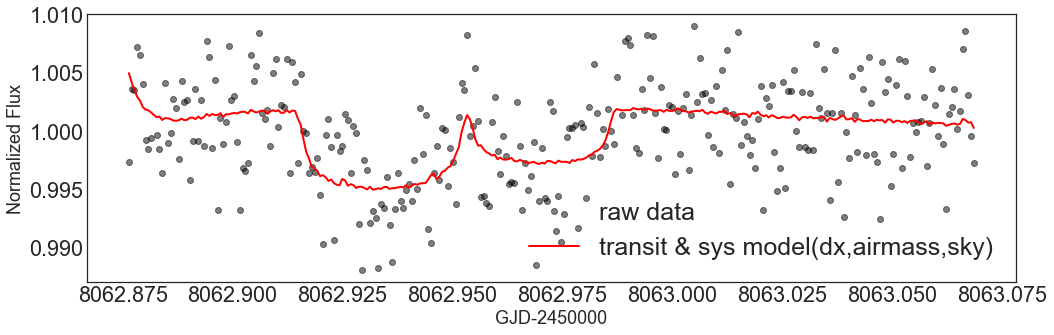

In [40]:
sys_use = sys_combination[21]
transit_params_after = transit_params_after_list[21]
sys_params_after = w_after[21]
full_params = np.concatenate((transit_params_after, sys_params_after), axis=0)

transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
sys_model = np.dot(sys_use,sys_params_after)

print('\nsystematics is' ,free[21])
#compute rms
rms_after = rms(flux/sys_model, transit_model)
print('rms w/o systematics:\n{:.8f}'.format(rms_after))
        
#compute BIC
num_d=len(time)
num_p=full_params.size
chi2 = chisq(flux/sys_model,transit_model,err)
        
dof = num_d - num_p
red_chi2 = chi2 / dof
BIC = chi2 + num_p * np.log(num_d)
        
print('chisq:\n{:.8f}'.format(chi2))
print('reduced_chisq:\n{:.8f}'.format(red_chi2))
print('BIC: {:.4f}'.format(BIC))

fig = pl.figure(figsize=(15,5))
#plot corrected data
pl.plot(time, flux, 'ko', alpha=0.5, label='raw data')
#pl.set_title('raw data & transit+systematics models (z-band)', fontsize=18)
#plot transit+sys models
pl.plot(time, transit_model*sys_model, 'r-', lw=2, label='transit & sys model(dx,airmass,sky)')
pl.xlabel('GJD-2450000')
pl.ylabel('Normalized Flux')
pl.legend(fontsize=25)
fig.tight_layout()
pl.savefig('figures/dxairmasssky.pdf')

ちなみにこのとき得られたTcは

In [41]:
Tc_d_after=transit_params_after_list[21][1]
Tc_e_after=transit_params_after_list[21][3]
print('Tc_d = ', Tc_d_after,'\nTc_e = ',Tc_e_after)

Tc_d =  8062.97007757 
Tc_e =  8062.93404277


In [42]:
Tc_d_after+2450000-2457738.3654 #need to convert BJD to GJD??

324.60467756865546

In [43]:
Tc_e_after+2450000-2457738.3654

324.5686427722685

In [44]:
TTV_d=(Tc_d_after-tc_0d)*24*60
TTV_e=(Tc_e_after-tc_0e)*24*60
print('TTV_d = ',TTV_d,'\nTTV_e = ',TTV_e)

TTV_d =  -7.34750094984 
TTV_e =  -15.6344077615


## 5. 最も良いパラメタセットでフィッティングする(MCMC)
### 5-1 likelihoodの準備

まずは各物理量に不確かさを入れた値を再度用意する。

In [48]:
import numpy as np
from uncertainties import ufloat 
from astropy import units as u

Rs   = ufloat(0.117,0.0036)#R_sun

Pe   = ufloat(6.099570,0.000091)#days これはTTV入ってないけどいいのか・・
Rpe  = ufloat(0.918,0.039) #R_earth

be   = ufloat(0.12,0.11)#+0.11/-0.09     
ae   = ufloat(0.02817,0.00087) #AU +0.00083/-0.00087

ke   = Rpe/Rs/u.Rsun.to(u.Rearth)
a_se = ae/Rs/u.Rsun.to(u.au)

Pd   = ufloat(4.04982,0.00017)#days
Rpd  = ufloat(0.772,0.030) #R_earth

bd   = ufloat(0.17,0.11)  
ad = ufloat(0.02144,0.00066) #AU +0.00066/-0.00063

kd   = Rpd/Rs/u.Rsun.to(u.Rearth)
a_sd = ad/Rs/u.Rsun.to(u.au)

これまではトランジットのfree parameterとしてkd,Tcd,ke,Tceしか動かさなかったが、ここからは各惑星のa_s,bと、lim-darkningのq_1,q_2もpriorを与えて動かすことにする。Pd,Peは相変わらず固定。  

と、いうことで、もう一度パラメタセットとtransit_modelの定義を用意しないといけない。　　
パラメタセットを
(k_d,tc_d,a_d,b_d,k_e,tc_e,a_e,b_e,q1,q2,w0,w1,w2,w3)とおくことにして・・・

In [70]:
def transit_model_q_new(parameters, fix, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * u1 : limb-darkening coefficient (for the linear term)
    * u2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k_d,tc_d,a_d,b_d,k_e,tc_e,a_e,b_e,q1,q2 = parameters
    p_d,p_e = fix
    
    #compute inclination
    inc_d   = np.arccos(b_d/a_d)
    inc_e   = np.arccos(b_e/a_e)
    #convert q to u
    u1,u2 = q_to_u(q1, q2)
    #evaluate the model
    m = 1-(1-model.evaluate(time, k_d, (u1,u2), tc_d, p_d, a_d, inc_d))-(1-model.evaluate(time, k_e, (u1,u2), tc_e, p_e,a_e, inc_e))
    
    return m

<font color=red>ここからやりかけ</font>  
ここからはMCMCを使う。
ベイズの定理より
$$
P(\theta|D) \propto P(\theta) \times P(D|\theta) \\
\rm{Posterior \propto Prior \times Likelihood}
$$
ここで$P(\theta)$ は prior, $P(D|\theta)$ は likelihood。

likelihoodをガウシアンとして
$$
\mathcal{L}(\theta|M) = N(\mu,\sigma) = \prod_{n=1}^{N}\frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(x_n-\mu)^2}{2\sigma^2}\right)
$$
logをとると
$$
\log \mathcal{L}(\theta|D) = -\frac{1}{2}\Big[N\log(2\pi) +2N\log\sigma +\sum_{n=1}^{N}\Big(\frac{x_n-\mu}{\sigma}\Big)^2\Big]
$$

<font color=red>Jeromeのコードではこの後$\sigma$にerrを利用しているけどそれでいいのか？？rmsとかでなく？</font>  

In [71]:
def loglike(params_full, fix, t, f, err,
            ret_mod=False, ret_sys=False, ret_full = False):
    '''
    * computes the log likelihood given the optimized transit and model parameters
    * either or both transit and systematics models can also be returned
    '''
    
    m = transit_model_q(params_full[:10],fix, t)
   
    w= params_full[10:]
    
    s = np.dot(sys_use,w)  
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m * s
    
    resid = f - s * m
    div   = resid/err
    N     = div.size
    
    return -sum(np.log(err)) -0.5*N*np.log(2*np.pi) -0.5*np.dot(div,div)

### 5-2 priorの準備
prior（uniformか？normalか？上限、下限は？）を物理的に適した値に設定する。

uniform priorが適しているのは
* Impact parameter
* White noise std
* limb darkening q1
* limb darkening q2

normal prior $N(\sigma,\mu)$が適しているのは
* Transit center
* Period
* Stellar density
* Baseline constant
* planet-star area ratio

priorを決める元となる様々な基準を用意

In [72]:
def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = np.arccos(b/a)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

In [73]:
from astropy import constants
from astropy import units

def rhostar(p, a): #これ理解しないと・・・Pとasに制限を加える
    """
    Eq.4 of Kipping 2014. 
    Assumes circular orbit & Mp<<Ms
    
    http://arxiv.org/pdf/1311.1170v3.pdf
    
    c.f. Seager & __ 2002
    """
    p = p * units.d
    gpcc = units.g / units.cm ** 3
    rho_mks = 3 * np.pi / constants.G / p ** 2 * a ** 3
    return rho_mks.to(gpcc).value

In [74]:
from scipy import stats
def logprior(full_params):
    '''
    full_paras: transit+systematic model parameters
    up: limb-darkening prior for u1,u2
    '''
    #unpack transit parameters
    k_d,tc_d,k_e,tc_e= full_params[:4]
    
    inc_d=np.arccos(b_d/a_s_d)
    inc_e=np.arccos(b_e/a_s_e)
    
    tshape_d = tshape_approx(a_s_d, k_d, b_d)
    tshape_e = tshape_approx(a_s_e, k_e, b_e)
    
    kmax_d = max_k(tshape_d)
    kmax_e = max_k(tshape_e)
    
    rho_s_d = rhostar(p_d, a_s_d)
    rho_s_e = rhostar(p_e, a_s_e)

    time_start = df['time'][0]
    time_end = df['time'][305]
    
    #Uniform priors: return log 0= inf if outside interval
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k_d   < 0 or k_d  > kmax_d or \
        k_e   < 0 or k_e  > kmax_e or \
        b_d   < 0 or b_d > 1 or \
        b_e   < 0 or b_e > 1 or \
        inc_d > np.pi/2 or \
        inc_e > np.pi/2 or \
        a_s_d < 0 or a_s_d  > 13 or \
        a_s_e < 0 or a_s_e  > 13 or \
        rho_s_d < 1 or rho_s_d > 10 or \
        rho_s_e < 1 or rho_s_e > 10:
        #tc_d　< time_start or  tc_d > time_end:
        #tc_e　< time_start or  tc_e > time_end:
        
        #print('off limits encountered in logprior')
        return -np.inf
    
    #if they are inside interval, add log 1 = 0 to logprior
    
    #logprior
    lp = 0
    
    #Normal priors on q1,q2 with sigma=uncertainty from Claret+2012
    u1,u2 = q_to_u(q1,q2)
    
    return lp

loglikeとlogpriorからlogprobを計算

In [75]:
def logprob(full_params,
            fix,
            time,
            flux,
            err):
    
    #sum loglike for each band
    ll  = loglike(full_params, fix, time, flux, err)
    lp  = logprior(full_params)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

今ある値を入れてみてlogprobを確認

In [76]:
free[21]

['dx', 'airmass', 'sky']

In [ ]:
plus = k_d,tc_d,a_d,b_d,k_e,tc_e,a_e,b_e,q1,q2

In [46]:
time = df['time']
flux = df['flux(13)']
err  = df['err(13)']
dx    = df['dx']
dy     = df['dy']
sky   = df['sky']

sys_use = sys_combination[21]
transit_params_after = transit_params_after_list[21]
sys_params_after = w_after[21]
full_params = np.concatenate((transit_params_after, sys_params_after), axis=0)

logprob(full_params,
        time,
        flux,
        sys_use,
        err)

TypeError: transit_model_q() missing 1 required positional argument: 'time'

あれぇ

In [77]:
import emcee
emcee.EnsembleSampler?

In [ ]:
bは動かしたほうがいいかも
statistical　comparisonの方法がある